In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import norm

In [9]:
data = pd.read_csv("Zprices.csv",header=None)
dataf = pd.read_csv("Zpricesf.csv",header=None)

Z = data.values
Zf = dataf.values
Times = 1- np.array([0,0.0310345,0.062069,0.0931034,0.124138,0.155172,0.186207,0.217241,0.248276,0.27931,0.310345,0.341379,0.372414,0.403448,0.434483,0.465517,0.496552,0.527586,0.558621,0.589655,0.62069,0.651724,0.682759,0.713793,0.744828,0.775862,0.806897,0.837931,0.868966,0.9])
K = np.array([100,109.091,118.182,127.273,136.364,145.455,154.545,163.636,172.727,181.818,190.909,200,209.091,218.182,227.273,236.364,245.455,254.545,263.636,272.727,281.818,290.909,300,309.091,318.182,327.273,336.364,345.455,354.545,363.636,372.727,381.818,390.909,400,409.091,418.182,427.273,436.364,445.455,454.545,463.636,472.727,481.818,490.909,500,509.091,518.182,527.273,536.364,545.455,554.545,563.636,572.727,581.818,590.909,600,609.091,618.182,627.273,636.364,645.455,654.545,663.636,672.727,681.818,690.909,700,709.091,718.182,727.273,736.364,745.455,754.545,763.636,772.727,781.818,790.909,800,809.091,818.182,827.273,836.364,845.455,854.545,863.636,872.727,881.818,890.909,900,909.091,918.182,927.273,936.364,945.455,954.545,963.636,972.727,981.818,990.909,1000])

x,y = np.meshgrid(Times,K)
Z.shape, x.shape

((100, 30), (100, 30))

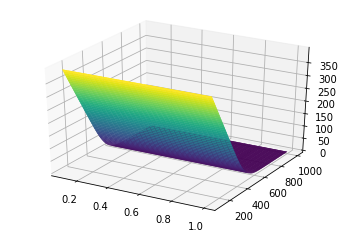

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none');
ax.plot_surface(x, y, Zf, rstride=1, cstride=1,cmap='viridis', edgecolor='none');

In [13]:
# all inputs must be scalar

def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

bs = np.vectorize(blackscholes_price)

def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The current price of the underlying asset.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0) or (S <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    # compute the time-value of the option
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

In [ ]:
IV = blackscholes_impv(y,x,500.,Z)
Zf = bs(y,x,500,0.15)
IVf =  blackscholes_impv(y,x,500.,Zf)

In [22]:
nans = np.isnan(Zf)
Zf[nans]

array([], dtype=float64)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot_surface(x, y, IV, rstride=1, cstride=1,cmap='viridis', edgecolor='none');
ax.plot_surface(x, y, IVf, rstride=1, cstride=1,cmap='viridis', edgecolor='none');